In [6]:
#导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from wordcloud import WordCloud
from dateutil.parser import parse
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

#设置jupyter可以多行输出
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

#jupyter绘图魔术方法
%matplotlib notebook
%matplotlib inline
#忽略警告
warnings.filterwarnings("ignore")

#读取数据
train_data = pd.read_csv(r'C:\Users\19360\Desktop\数据\train.csv')
test_data = pd.read_csv(r'C:\Users\19360\Desktop\数据\test.csv')

In [7]:
#查看对象尺度
train_data.shape
test_data.shape

(3000, 23)

(4398, 22)

In [8]:
#训练集总览
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [9]:
#训练集和测试集的空值一览
train_data.isna().sum()
test_data.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [10]:
train_data[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [11]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else eval(x) )
    return df
        
train_data = text_to_dict(train_data)
test_data = text_to_dict(test_data)

In [12]:
train_data[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [13]:
train_data['belongs_to_collection'].map(lambda x:len(x) if x!='{}' else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [14]:
#训练集处理
train_data['has_collection'] = train_data['belongs_to_collection'].map(lambda x:1 if x!={} else 0)

#测试集处理
test_data['has_collection'] = test_data['belongs_to_collection'].map(lambda x:1 if x!={} else 0)

<AxesSubplot:>

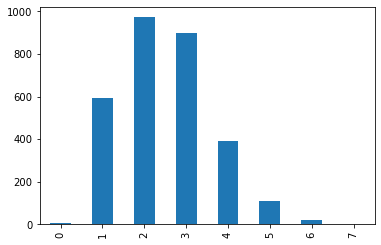

In [15]:
(train_data['genres'].map(lambda x:len(x) if x!={} else 0).value_counts().sort_index()).plot(kind='bar')

In [16]:
#训练集处理
train_data['genres_num'] = train_data['genres'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['genres_num'] = test_data['genres'].map(lambda x:len(x) if x!={} else 0)

In [17]:
#训练集处理
train_data['genres_all'] = train_data['genres'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['genres_all'] = test_data['genres'].map(lambda x:','.join([i['name'] for i in x]))

In [18]:
train_data['genres_all'][:5]

0                         Comedy
1    Comedy,Drama,Family,Romance
2                          Drama
3                 Thriller,Drama
4                Action,Thriller
Name: genres_all, dtype: object

In [19]:
list_genres = list(train_data['genres'].map(lambda x:[i['name'] for i in x]))

list_genres_count = []
for i in list_genres:
    for j in i:
        list_genres_count.append(j)

([], [])

([], [])

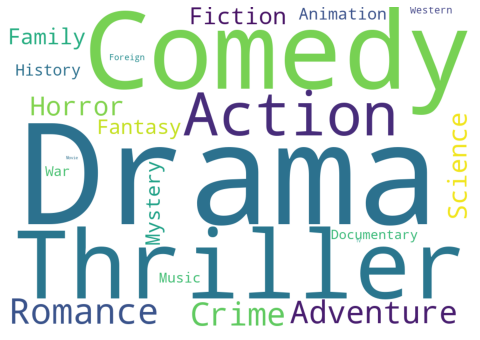

In [20]:
#%matplotlib notebook
fig,ax=plt.subplots(figsize=(12,6))
w = WordCloud( \
    width = 1000, height = 700,\
    background_color = "white",
    collocations=False
    ).generate(','.join(list_genres_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [21]:
genres_top = Counter(list_genres_count).most_common()

In [22]:
list_genres_count = Counter(list_genres_count)
list_genres_count = list(list_genres_count)

In [23]:
#训练集处理
for i in list(list_genres_count):
    train_data['genres_'+i] = train_data['genres_all'].map(lambda x:1 if i in x else 0)

#测试集处理
for i in list(list_genres_count):
    test_data['genres_'+i] = test_data['genres_all'].map(lambda x:1 if i in x else 0)

In [25]:
#训练集处理
train_data['has_homepage'] = train_data['homepage'].map(lambda x:0 if pd.isna(x) else 1)

#测试集处理
test_data['has_homepage'] = test_data['homepage'].map(lambda x:0 if pd.isna(x) else 1)

In [26]:
train_data['original_language'][:5]

0    en
1    en
2    en
3    hi
4    ko
Name: original_language, dtype: object

In [27]:
len(train_data['original_language'].value_counts())

36

In [28]:
len(train_data['original_language'].value_counts())

36

<AxesSubplot:xlabel='original_language', ylabel='count'>

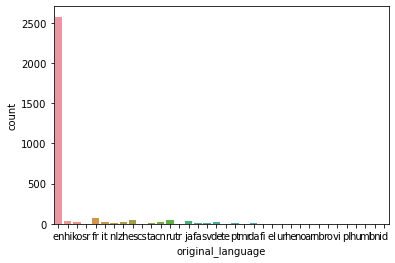

In [29]:
sns.countplot(train_data['original_language'])

In [30]:
original_language_list = [i[0] for i in Counter(train_data['original_language']).most_common(15)]

In [31]:
#训练集处理
for i in original_language_list:
    train_data['orginal_language_' + i] = train_data['original_language'].map(lambda x:1 if x==i else 0 )

    #测试集处理
for i in original_language_list:
    test_data['orginal_language_' + i] = test_data['original_language'].map(lambda x:1 if x==i else 0 )

In [32]:
#训练集处理
train_data['pr_companies_num'] = train_data['production_companies'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['pr_companies_num'] = test_data['production_companies'].map(lambda x:len(x) if x!={} else 0)

<AxesSubplot:xlabel='pr_companies_num', ylabel='count'>

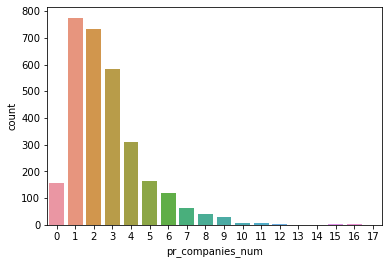

In [33]:
sns.countplot(train_data['pr_companies_num'])

In [34]:
#测试集处理
train_data['companies_all'] = train_data['production_companies'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['companies_all'] = test_data['production_companies'].map(lambda x:','.join([i['name'] for i in x]))

In [35]:
list_companies = list(train_data['production_companies'].map(lambda x:[i['name'] for i in x]))

list_companies_count = []
for i in list_companies:
    for j in i:
        list_companies_count.append(j)

In [36]:
companies_top = Counter(list_companies_count).most_common()
len(Counter(list_companies_count))

3695

In [37]:
production_companies_count_list = [i[0] for i in Counter(list_companies_count).most_common(30)]

In [38]:
#训练集处理
for i in production_companies_count_list:
    train_data['companies_' + i] = train_data['companies_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in production_companies_count_list:
    test_data['companies_' + i] = test_data['companies_all'].map(lambda x:1 if i in x else 0 )

In [39]:
train_data['production_countries'][:3]

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

In [40]:
#训练集处理
train_data['pr_countries_num'] = train_data['production_countries'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['pr_countries_num'] = test_data['production_countries'].map(lambda x:len(x) if x!={} else 0)

In [41]:
#测试集处理，新增一列，将出品方国家从json中分离出来
train_data['countries_all'] = train_data['production_countries'].map(lambda x:','.join([i['iso_3166_1'] for i in x]))

#测试集处理，新增一列，将出品方国家从json中分离出来
test_data['countries_all'] = test_data['production_countries'].map(lambda x:','.join([i['iso_3166_1'] for i in x]))

In [42]:
list_countries = list(train_data['production_countries'].map(lambda x:[i['iso_3166_1'] for i in x]))

list_countries_count = []
for i in list_countries:
    for j in i:
        list_countries_count.append(j)

([], [])

([], [])

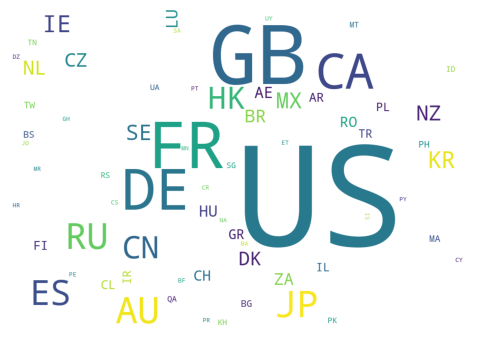

In [43]:
fig,ax=plt.subplots(figsize=(12,6))
w = WordCloud( \
    width = 1000, height = 700,\
    background_color = "white",
    collocations=False
    ).generate(','.join(list_countries_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

<AxesSubplot:xlabel='0'>

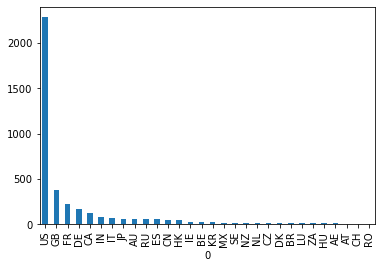

In [44]:
pd.DataFrame(Counter(list_countries_count).most_common(30)).set_index([0]).iloc[:,0].plot(kind='bar')

In [45]:
len(Counter(list_countries_count))

74

In [46]:
countries_top = Counter(list_countries_count).most_common()

In [47]:
production_countries_count_list = [i[0] for i in Counter(list_countries_count).most_common(25)]

In [48]:
#训练集处理
for i in production_countries_count_list:
    train_data['pr_countries_' + i] = train_data['countries_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in production_countries_count_list:
    test_data['pr_countries_' + i] = test_data['countries_all'].map(lambda x:1 if i in x else 0 )

In [49]:
def func_one(x):
    if x<=3:
        return 1
    elif x<=6:
        return 2
    elif x<=9:
        return 3
    else:
        return 4

In [50]:
train_data['release_year'] = train_data['release_date'].map(lambda x:parse(x).year)
train_data['release_month'] = train_data['release_date'].map(lambda x:parse(x).month)
train_data['release_day'] = train_data['release_date'].map(lambda x:parse(x).day)
train_data['release_weekday']  = train_data['release_date'].map(lambda x:parse(x).isoweekday())
train_data['release_quarter']  = train_data['release_month'].map(func_one)

In [51]:
test_data.loc[test_data['release_date'].isnull(),'release_date']='1/1/2000'

In [52]:
test_data['release_year'] = test_data['release_date'].map(lambda x:parse(x).year)
test_data['release_month'] = test_data['release_date'].map(lambda x:parse(x).month)
test_data['release_day'] = test_data['release_date'].map(lambda x:parse(x).day)
test_data['release_weekday']  = test_data['release_date'].map(lambda x:parse(x).isoweekday())
test_data['release_quarter']  = test_data['release_month'].map(func_one)

In [53]:
def fun_year(x):
    if x>2019:
        x = x-100
    return x

train_data['release_year'] = train_data['release_year'].map(fun_year)

test_data['release_year'] = test_data['release_year'].map(fun_year)

In [54]:
#训练集处理
train_data['runtime'] = train_data['runtime'].fillna(train_data['runtime'].mode()[0])

#测试集处理
test_data['runtime'] = test_data['runtime'].fillna(test_data['runtime'].mode()[0])

In [55]:
train_data['spoken_languages'][:2]

0    [{'iso_639_1': 'en', 'name': 'English'}]
1    [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

In [56]:
#训练集处理
train_data['spoken_languages_num'] = train_data['spoken_languages'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['spoken_languages_num'] = test_data['spoken_languages'].map(lambda x:len(x) if x!={} else 0)

In [57]:
#测试集处理
train_data['spoken_languages_all'] = train_data['spoken_languages'].map(lambda x:','.join([i['iso_639_1'] for i in x]))

#测试集处理
test_data['spoken_languages_all'] = test_data['spoken_languages'].map(lambda x:','.join([i['iso_639_1'] for i in x]))

In [58]:
list_spoken_languages = list(train_data['spoken_languages'].map(lambda x:[i['iso_639_1'] for i in x]))

list_spoken_languages_count = []
for i in list_spoken_languages:
    for j in i:
        list_spoken_languages_count.append(j)

In [59]:
languages_top = Counter(list_spoken_languages_count).most_common()

In [60]:
spoken_languages_count_list = [i[0] for i in Counter(list_spoken_languages_count).most_common(25)]

In [61]:
#训练集处理
for i in spoken_languages_count_list:
    train_data['spoken_languages_' + i] = train_data['spoken_languages_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in spoken_languages_count_list:
    test_data['spoken_languages_' + i] = test_data['spoken_languages_all'].map(lambda x:1 if i in x else 0 )

In [62]:
train_data['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [63]:
train_data['has_Released'] = train_data['status'].map(lambda x:1 if x=='Released' else 0)

test_data['has_Released'] = test_data['status'].map(lambda x:1 if x=='Released' else 0)

In [64]:
train_data['has_tagline'] = train_data['tagline'].map(lambda x:0 if pd.isna(x) else 1)

test_data['has_tagline'] = test_data['tagline'].map(lambda x:0 if pd.isna(x) else 1)

In [65]:
#训练集处理
train_data['Keywords_num'] = train_data['Keywords'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['Keywords_num'] = test_data['Keywords'].map(lambda x:len(x) if x!={} else 0)

In [66]:
#训练集处理
train_data['Keywords_all'] = train_data['Keywords'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['Keywords_all'] = test_data['Keywords'].map(lambda x:','.join([i['name'] for i in x]))

In [67]:
list_Keywords = list(train_data['Keywords'].map(lambda x:[i['name'] for i in x]))

list_Keywords_count = []
for i in list_Keywords:
    for j in i:
        list_Keywords_count.append(j)

In [68]:
keywords_top = Counter( list_Keywords_count).most_common()

([], [])

([], [])

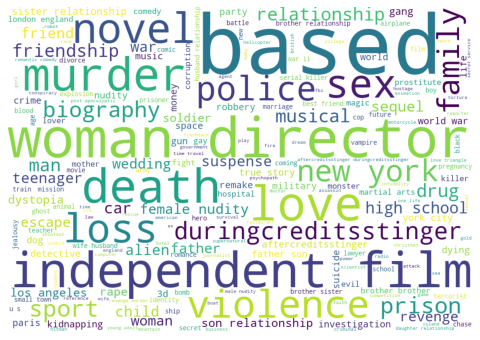

In [69]:
fig,ax=plt.subplots(figsize=(12,6))
w = WordCloud( \
    width = 1000, height = 700,
    background_color = "white",
    collocations=True
    ).generate(','.join(list_Keywords_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [70]:
list_Keywords_count = [i[0] for i in Counter(list_Keywords_count).most_common(30)]

In [71]:
#训练集处理
for i in list(list_Keywords_count):
    train_data['Keywords_'+i] = train_data['Keywords_all'].map(lambda x:1 if i in x else 0)

#测试集处理
for i in list(list_Keywords_count):
    test_data['Keywords_'+i] = test_data['Keywords_all'].map(lambda x:1 if i in x else 0)

In [72]:
#训练集处理
train_data['cast_num'] = train_data['cast'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['cast_num'] = test_data['cast'].map(lambda x:len(x) if x!={} else 0)

In [73]:
#训练集处理
train_data['cast_all'] = train_data['cast'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['cast_all'] = test_data['cast'].map(lambda x:','.join([i['name'] for i in x]))

In [74]:
list_cast = list(train_data['cast'].map(lambda x:[i['name'] for i in x]))

list_cast_count = []
for i in list_cast:
    for j in i:
        list_cast_count.append(j)

In [75]:
cast_top = Counter(  list_cast_count).most_common()

In [76]:
list_cast_count = [i[0] for i in Counter(list_cast_count).most_common(30)]

In [77]:
for i in list(list_cast_count):
    train_data['cast_'+i] = train_data['cast_all'].map(lambda x:1 if i in x else 0)

for i in list(list_cast_count):
    test_data['cast_'+i] = test_data['cast_all'].map(lambda x:1 if i in x else 0)

In [78]:
train_data['gender_0_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_data['gender_1_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_data['gender_2_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test_data['gender_0_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_data['gender_1_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_data['gender_2_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

In [79]:
#训练集处理
train_data['crew_num'] = train_data['crew'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['crew_num'] = test_data['crew'].map(lambda x:len(x) if x!={} else 0)

In [80]:
#训练集处理
train_data['crew_all'] = train_data['crew'].map(lambda x:','.join([i['name'] for i in x]))
train_data['crew_department_all'] = train_data['crew'].map(lambda x:','.join([i['department'] for i in x]))

#测试集处理
test_data['crew_all'] = test_data['crew'].map(lambda x:','.join([i['name'] for i in x]))
test_data['crew_department_all'] = test_data['crew'].map(lambda x:','.join([i['department'] for i in x]))

In [81]:
list_crew = list(train_data['crew'].map(lambda x:[i['name'] for i in x]))

list_crew_count = []
for i in list_crew:
    for j in i:
        list_crew_count.append(j)

crew_top = Counter(list_crew_count).most_common()

list_department = list(train_data['crew'].map(lambda x:[i['department'] for i in x]))

list_department_count = []
for i in list_department:
    for j in i:
        list_department_count.append(j)

department_top = Counter( list_department_count).most_common()

In [82]:
list_crew_count = [i[0] for i in Counter(list_crew_count).most_common(30)]

list_department_count = [i[0] for i in Counter(list_department_count).most_common()]

In [83]:
for i in list(list_crew_count):
    train_data['crew_'+i] = train_data['crew_all'].map(lambda x:1 if i in x else 0)

for i in list(list_crew_count):
    test_data['crew_'+i] = test_data['crew_all'].map(lambda x:1 if i in x else 0)

for i in list(list_department_count):
    train_data['department_'+i] = train_data['crew_department_all'].map(lambda x:1 if i in x else 0)

for i in list(list_department_count):
    test_data['department_'+i] = test_data['crew_department_all'].map(lambda x:1 if i in x else 0)

In [84]:
train_data['gender_0_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_data['gender_1_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_data['gender_2_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test_data['gender_0_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_data['gender_1_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_data['gender_2_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

<AxesSubplot:xlabel='revenue', ylabel='Density'>

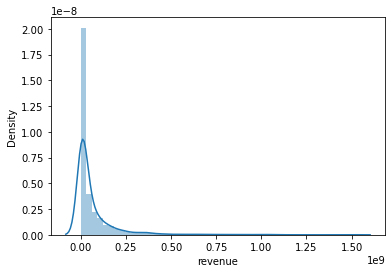

In [85]:
sns.distplot(train_data['revenue'])

<AxesSubplot:xlabel='revenue_log', ylabel='Density'>

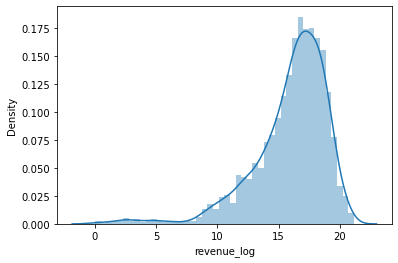

In [86]:
train_data['revenue_log'] = np.log(train_data['revenue'])
sns.distplot(train_data['revenue_log'])

In [87]:
train_data.shape
test_data.shape

(3000, 271)

(4398, 269)

In [88]:
train_drop_col = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_language','original_title',
           'poster_path','production_companies','production_countries','release_date','spoken_languages',
           'status','tagline','title','Keywords','cast','crew','revenue','revenue_log','genres_all','companies_all','countries_all',
                 'spoken_languages_all','Keywords_all','cast_all','crew_all','crew_department_all']

test_drop_col = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_language','original_title',
           'poster_path','production_companies','production_countries','release_date','spoken_languages',
           'status','tagline','title','Keywords','cast','crew','genres_all','companies_all','countries_all','spoken_languages_all',
                'Keywords_all','cast_all','crew_all','crew_department_all']

In [89]:
X_train = train_data.drop(train_drop_col,axis=1)
y_train = train_data.loc[:,'revenue_log']

X_test = test_data.drop(test_drop_col,axis=1)

In [90]:
xgbrfr = XGBRegressor()
xgbrfr.fit(X_train,y_train)
y_pred = xgbrfr.predict(X_test)

submission=pd.DataFrame({'id':test_data['id'] , 'revenue':[max(0,x) for x in np.exp(y_pred)]})
submission.to_csv('moviebox_predictions_2.0.csv',index=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [93]:
svc_rfr = cross_val_score(estimator=xgbrfr,X=X_train,y=y_train,cv=4)
svc_rfr.mean()

[20:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gramma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gramma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gramma" } might not be used.

  This could be a false

0.526936918231226

In [92]:
xgbrfr = XGBRegressor(min_child_weight=5,max_depth=6,gramma=0.1,subsample=0.9,colsample_bytree=0.7,reg_alpha=3,
                      reg_lambda=0.05,learning_rate=0.1)

xgbrfr.fit(X_train,y_train)
y_pred = xgbrfr.predict(X_test)

submission=pd.DataFrame({'id':test_data['id'] , 'revenue':[max(0,x) for x in np.exp(y_pred)]})
submission.to_csv('xgb_moviebox_predictions_2.0.csv',index=False)

[19:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gramma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, gramma=0.1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=0.05, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)